In [2]:
import zipfile, os

with zipfile.ZipFile("/0010.zip", "r") as zip_ref:
    zip_ref.extractall("data_0010")

for root, dirs, files in os.walk("data_0010"):
    print(root, len(files))
#os.walk扫描整个文件树（最常用）

data_0010 0
data_0010/0018 2
data_0010/0018/Surprise 350
data_0010/0018/Sad 350
data_0010/0018/Neutral 350
data_0010/0018/Angry 350
data_0010/0018/Happy 350
data_0010/0019 2
data_0010/0019/Surprise 350
data_0010/0019/Sad 350
data_0010/0019/Neutral 350
data_0010/0019/Angry 350
data_0010/0019/Happy 351
data_0010/0017 2
data_0010/0017/Surprise 350
data_0010/0017/Sad 350
data_0010/0017/Neutral 350
data_0010/0017/Angry 350
data_0010/0017/Happy 350


In [3]:
!pip install speechbrain torchaudio tqdm
!pip install transformers torchaudio librosa tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 57.0 MB/s eta 0:00:00


In [6]:
!pip install praat-parselmouth tqdm pandas numpy
import os
import pandas as pd
import numpy as np
import parselmouth
from tqdm import tqdm

base_dir = "data_0010"

def extract_features(path):
    try:
        snd = parselmouth.Sound(path)
        #parselmouth.Sound读取文件
        pitch = snd.to_pitch()
        #用 Praat 算法提取基频
        intensity = snd.to_intensity()
        #提取强度
        f0_values = pitch.selected_array['frequency']
        f0_values = f0_values[f0_values > 0]
        mean_f0 = np.mean(f0_values) if len(f0_values) > 0 else 0
        #mean_f0说话人平均音高
        stdev_f0 = np.std(f0_values) if len(f0_values) > 0 else 0
        #stdev_f0音高变化幅度，情绪激烈，标准差大
        mean_intensity = np.mean(intensity.values[0])
        #平均强度（声压的平均值）；
        duration = snd.get_total_duration()
        #语音时长（以秒为单位）
        intensity_values = intensity.values[0]
        active_frames = np.sum(intensity_values > (np.mean(intensity_values) + np.std(intensity_values)/2))
        #计算语音中“有声帧”的数量（即强度超过平均值 + 半个标准差的帧数）；
        speech_rate = active_frames / duration if duration > 0 else 0
        #用“活跃帧数 / 总时长”近似表示语速（speech rate）。
        return {
            "mean_f0": mean_f0,
            "stdev_f0": stdev_f0,
            "mean_intensity": mean_intensity,
            "speech_rate": speech_rate,
            "duration": duration
        }
    except:
        return {"mean_f0": 0, "stdev_f0": 0, "mean_intensity": 0, "speech_rate": 0, "duration": 0}

records = []

# 遍历每个子目录（0017、0018、0019...）
for speaker_dir in os.listdir(base_dir):
    speaker_path = os.path.join(base_dir, speaker_dir)
    if not os.path.isdir(speaker_path):
        continue

    for emotion in os.listdir(speaker_path):
        emotion_dir = os.path.join(speaker_path, emotion)
        if not os.path.isdir(emotion_dir):
            continue

        files = [f for f in os.listdir(emotion_dir) if f.endswith(".wav")]
        for f in tqdm(files, desc=f"Processing {speaker_dir}/{emotion}"):
            path = os.path.join(emotion_dir, f)
            feats = extract_features(path)
            feats["speaker"] = speaker_dir
            feats["emotion"] = emotion
            records.append(feats)

df = pd.DataFrame(records)
summary = df.groupby(["speaker", "emotion"])[["mean_f0", "stdev_f0", "mean_intensity", "speech_rate","duration"]].mean().round(2)

print("\n各子文件夹下的声学特征均值：")
print(summary)
summary.to_csv("emotion_acoustic_summary_all.csv")
print("\n结果已保存为 emotion_acoustic_summary_all.csv")


Processing 0017/Happy: 100%|██████████| 350/350 [00:05<00:00, 61.98it/s]


各子文件夹下的声学特征均值：
                  mean_f0  stdev_f0  mean_intensity  speech_rate  duration
speaker emotion                                                           
0017    Angry      222.17     57.40           40.22        52.25      3.19
        Happy      320.06    107.23           46.84        53.38      2.53
        Neutral    195.81     40.36           48.07        54.39      2.55
        Sad        200.02     36.27           48.89        56.49      2.84
        Surprise   276.11    100.16           49.64        53.54      2.55
0018    Angry      272.94     59.10           50.89        48.12      2.76
        Happy      296.55     60.77           49.64        52.00      2.45
        Neutral    246.93     46.99           49.70        51.40      2.72
        Sad        261.57     36.99           50.82        52.51      2.79
        Surprise   373.10     79.90           53.69        51.08      2.49
0019    Angry      169.10     44.53           50.74        50.88      2.71
        H

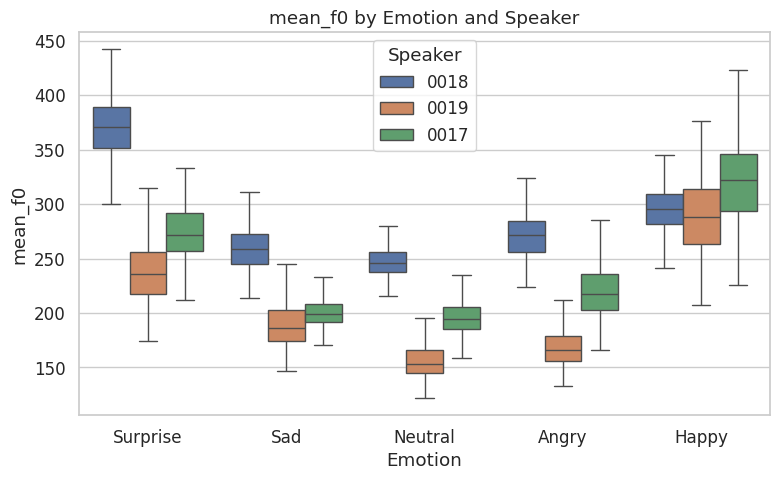

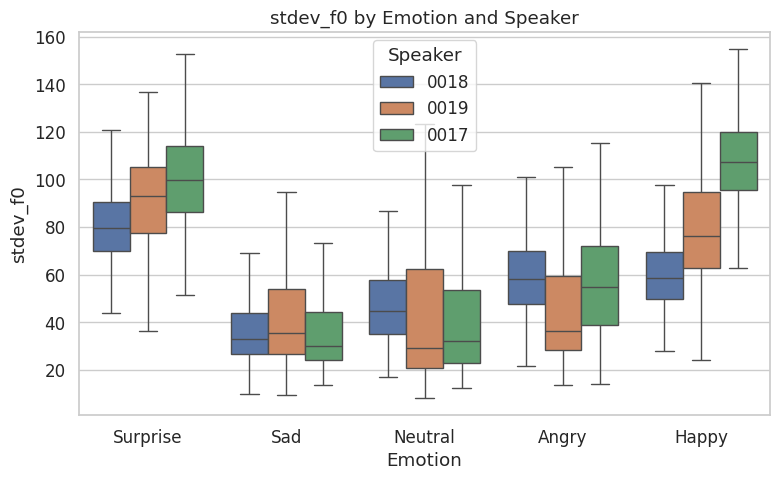

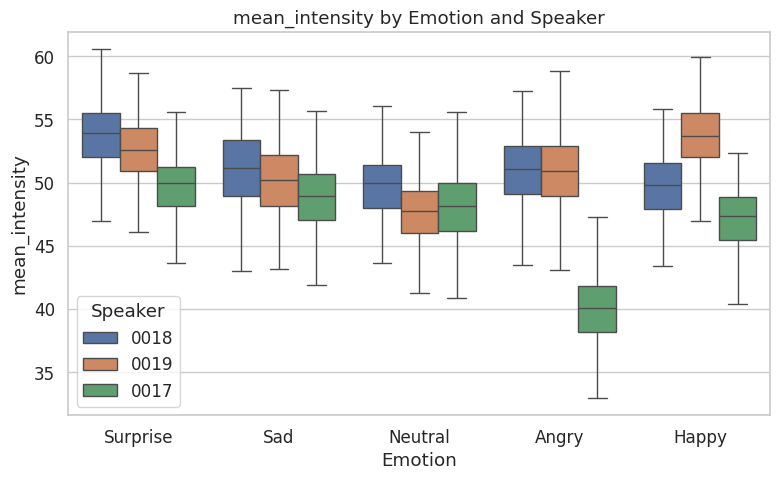

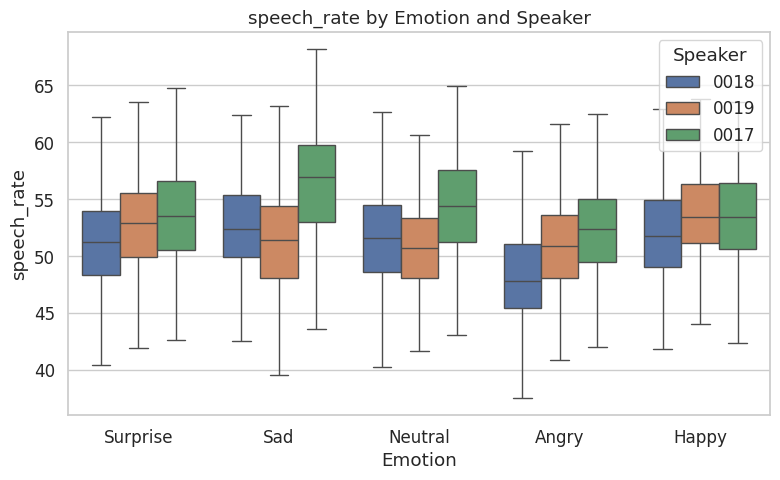

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", font_scale=1.1)

features = ["mean_f0", "stdev_f0", "mean_intensity", "speech_rate"]

for feat in features:
    plt.figure(figsize=(8,5))
    sns.boxplot(x="emotion", y=feat, hue="speaker", data=df, showfliers=False)
    plt.title(f"{feat} by Emotion and Speaker")
    plt.xlabel("Emotion")
    plt.ylabel(feat)
    plt.legend(title="Speaker")
    plt.tight_layout()
    plt.show()



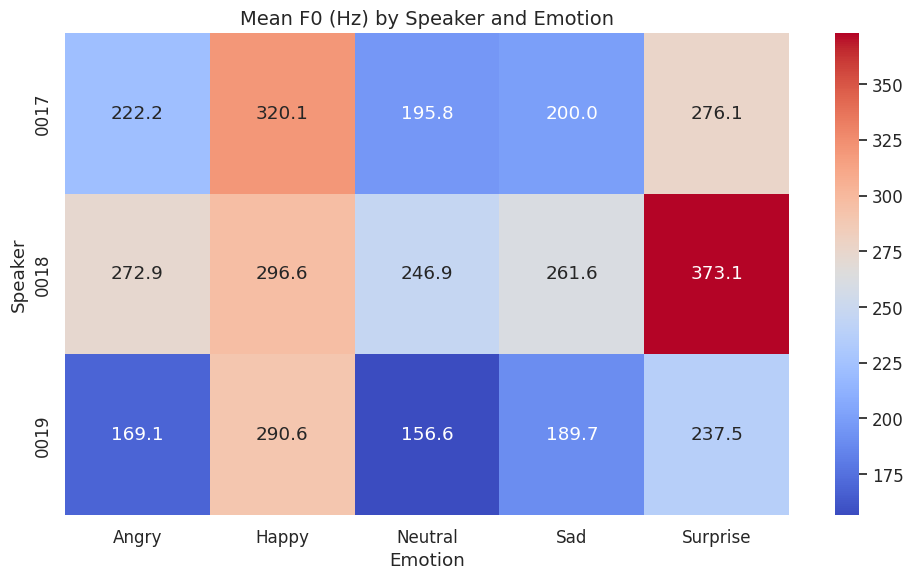

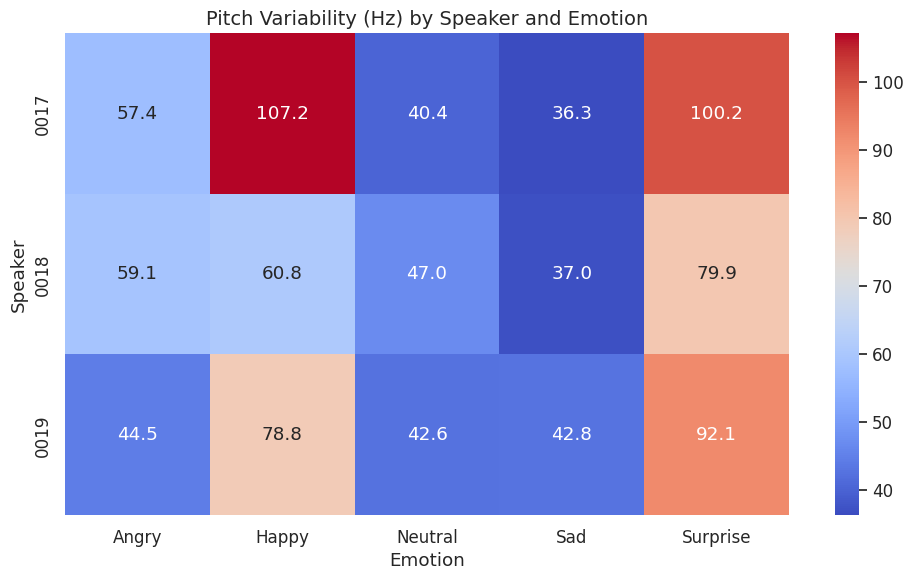

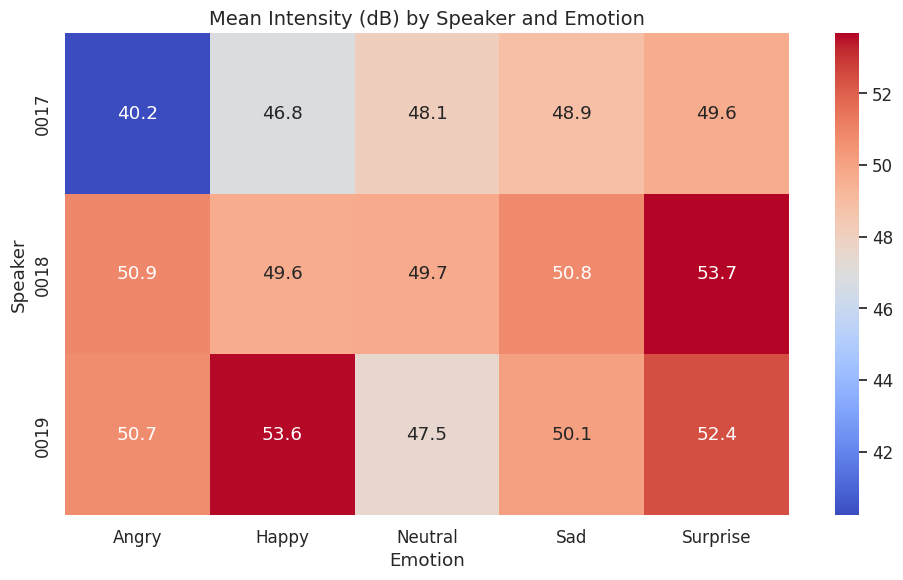

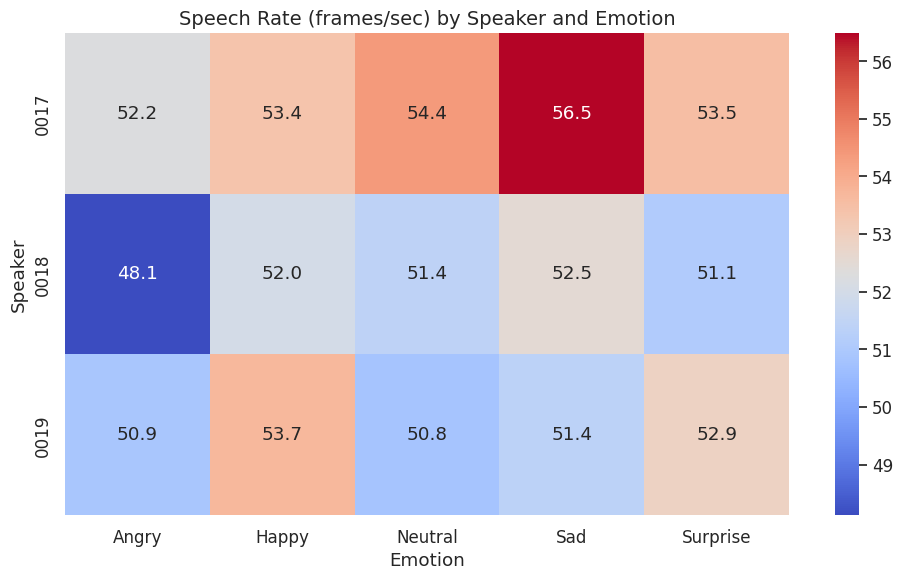

In [11]:
features = [
    ("mean_f0", "Mean F0 (Hz)"),
    ("stdev_f0", "Pitch Variability (Hz)"),
    ("mean_intensity", "Mean Intensity (dB)"),
    ("speech_rate", "Speech Rate (frames/sec)")
]
pivot_data = summary.reset_index()
for feature, title in features:
    plt.figure(figsize=(10,6))
    sns.heatmap(
        pivot_data.pivot(index="speaker", columns="emotion", values=feature),
        annot=True, fmt=".1f", cmap="coolwarm"
    )
    plt.title(f"{title} by Speaker and Emotion", fontsize=14)
    plt.xlabel("Emotion")
    plt.ylabel("Speaker")
    plt.tight_layout()
    plt.show()